<a href="https://colab.research.google.com/github/kasapmont-ux/Cnn/blob/main/65070502469_Takehome2_file1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Given CNN

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')



# ตรวจสอบใน 2.CNN
!ls /content/drive/MyDrive/ene490/archive/logos3/train



Mounted at /content/drive
'Burger King'   KFC   McDonalds   Other   Starbucks   Subway


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

Hyperparameters:
  Learning Rate: 0.0005
  Batch Size: 32
  Epochs: 20
  Weight Decay: 0.0001

Dataset Info:
  Training samples: 1738
  Test samples: 560
  Classes: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']

Model Parameters:
  Total parameters: 301,380,968
  Trainable parameters: 301,380,968
  Model size: ~1149.7 MB

TRAINING STARTED
Epoch [1/20] | Loss: 1.5300 | Train Acc: 61.68% | Test Acc: 42.86%
Epoch [2/20] | Loss: 0.9288 | Train Acc: 77.33% | Test Acc: 50.54%
Epoch [3/20] | Loss: 0.7069 | Train Acc: 78.14% | Test Acc: 51.96%
Epoch [4/20] | Loss: 0.6329 | Train Acc: 81.70% | Test Acc: 51.79%
Epoch [5/20] | Loss: 0.5547 | Train Acc: 83.60% | Test Acc: 55.54%
Epoch [6/20] | Loss: 0.5187 | Train Acc: 85.44% | Test Acc: 54.11%
Epoch [7/20] | Loss: 0.4935 | Train Acc: 86.65% | Test Acc: 55.54%
Epoch [8/20] | Loss

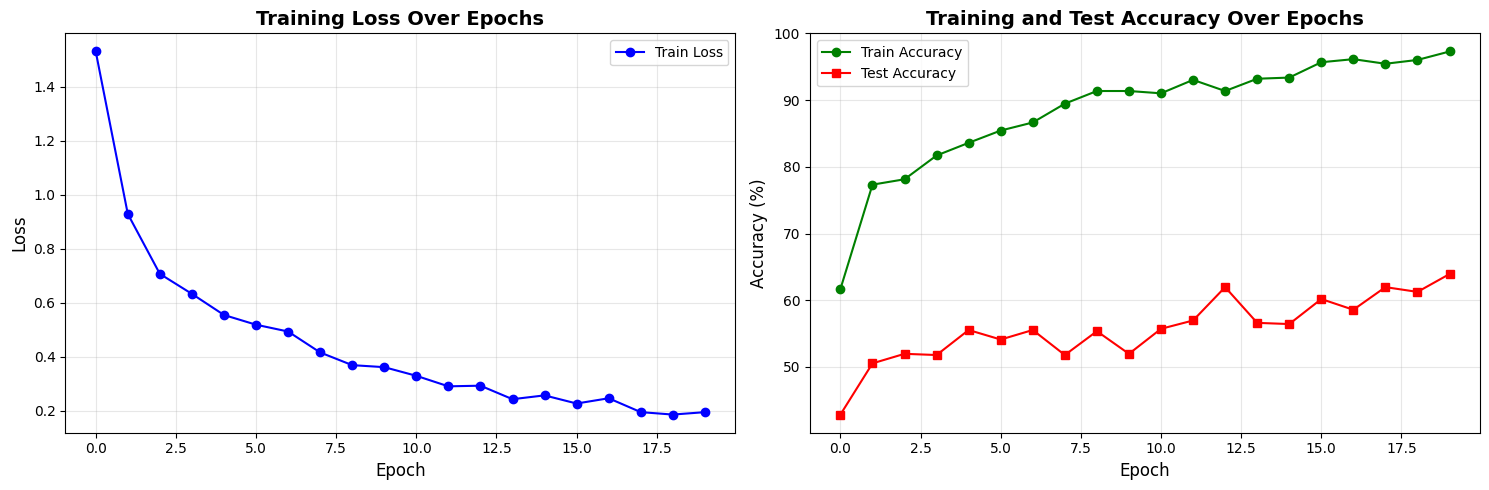


FINAL EVALUATION

Final Train Accuracy: 97.07%
Final Test Accuracy: 63.93%

MEASURING INFERENCE TIME
Average inference time: 0.03 ms per image

GENERATING PREDICTIONS FOR METRICS

Weighted Metrics:
  Precision: 0.6159
  Recall:    0.6393
  F1-Score:  0.6068


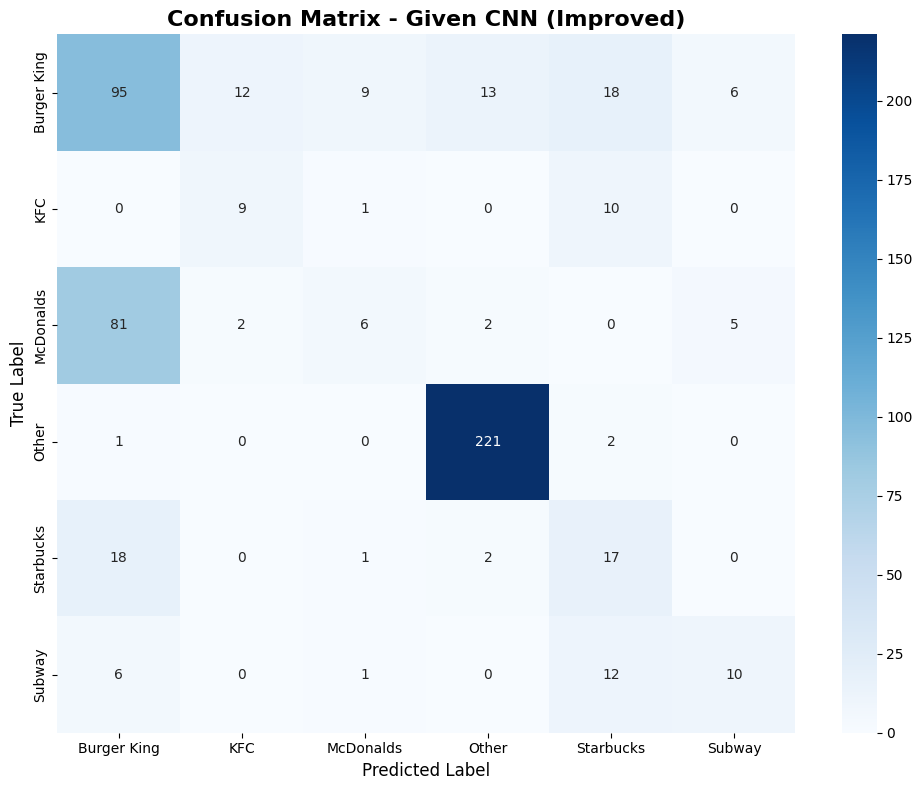


CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Burger King     0.4726    0.6209    0.5367       153
         KFC     0.3913    0.4500    0.4186        20
   McDonalds     0.3333    0.0625    0.1053        96
       Other     0.9286    0.9866    0.9567       224
   Starbucks     0.2881    0.4474    0.3505        38
      Subway     0.4762    0.3448    0.4000        29

    accuracy                         0.6393       560
   macro avg     0.4817    0.4854    0.4613       560
weighted avg     0.6159    0.6393    0.6068       560


📊 FOR REPORT - SUMMARY TABLE

📈 Performance:
  Test Accuracy:        63.93%
  Precision (Weighted): 0.6159
  Recall (Weighted):    0.6393
  F1-Score (Weighted):  0.6068

🏗️ Architecture:
  Parameters:        301,380,968
  Layers/Blocks:     2 Conv layers + 3 FC layers
  Pretrained:        No

⚡ Efficiency:
  Training Time:     22.6 min
  Inference Time:    0.03 ms per image
  Memory Usage:      ~1149.7 MB

📋 COPY THIS FOR YOUR CO

In [3]:
# ============================================================================
# Given CNN - Improved Version with Better Hyperparameters
# Based on instructor's original code with enhancements
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sn
import pandas as pd
import numpy as np
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 1. DATA PREPARATION (Improved with Data Augmentation)
# ============================================================================
train_dir = os.path.join('/content/drive/MyDrive/ene490/archive/logos3/train')
test_dir = os.path.join('/content/drive/MyDrive/ene490/archive/logos3/test')

# Enhanced training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomHorizontalFlip(p=0.5),      # NEW: Random flip
    transforms.RandomRotation(15),                # NEW: Random rotation
    transforms.ColorJitter(brightness=0.2,        # NEW: Color variation
                          contrast=0.2,
                          saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                        std=[0.5, 0.5, 0.5])
])

# ============================================================================
# 2. HYPERPARAMETERS (Improved)
# ============================================================================

# Original hyperparameters (for comparison)
ORIGINAL_CONFIG = {
    'num_classes': 6,
    'learning_rate': 0.001,
    'batch_size': 32,
    'num_epoch': 2
}

# IMPROVED hyperparameters
IMPROVED_CONFIG = {
    'num_classes': 6,
    'learning_rate': 0.0005,        # Reduced for better convergence
    'batch_size': 32,                # Keep same
    'num_epoch': 20,                 # INCREASED from 2 to 20
    'weight_decay': 1e-4             # NEW: L2 regularization
}

# Choose configuration
CONFIG = IMPROVED_CONFIG

num_classes = CONFIG['num_classes']
learning_rate = CONFIG['learning_rate']
batch_size = CONFIG['batch_size']
num_epoch = CONFIG['num_epoch']
weight_decay = CONFIG.get('weight_decay', 0)

print(f"\nHyperparameters:")
print(f"  Learning Rate: {learning_rate}")
print(f"  Batch Size: {batch_size}")
print(f"  Epochs: {num_epoch}")
print(f"  Weight Decay: {weight_decay}")

# ============================================================================
# 3. LOAD DATASET
# ============================================================================

train_data = torchvision.datasets.ImageFolder(root=train_dir,
                                              transform=train_transform)
train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=batch_size,
                                                shuffle=True)  # Always shuffle training data

test_data = torchvision.datasets.ImageFolder(root=test_dir,
                                             transform=test_transform)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                               batch_size=batch_size,
                                               shuffle=False)

print(f"\nDataset Info:")
print(f"  Training samples: {len(train_data)}")
print(f"  Test samples: {len(test_data)}")
print(f"  Classes: {train_data.classes}")

# ============================================================================
# 4. MODEL DEFINITION (Same as instructor's original)
# ============================================================================

class CNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=6):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6,
                              kernel_size=(5,5), stride=(1,1), padding='valid')
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=14,
                              kernel_size=(5,5), stride=(1,1), padding='valid')
        self.fc1 = nn.Linear(72*72*14, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, num_classes)

        # NEW: Add dropout for regularization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # NEW: Apply dropout
        x = F.relu(self.fc2(x))
        x = self.dropout(x)  # NEW: Apply dropout
        x = self.fc3(x)
        return x

# Initialize model
model = CNN(num_classes=num_classes).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
param_size_mb = (total_params * 4) / (1024 * 1024)

print(f"\nModel Parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{param_size_mb:.1f} MB")

# ============================================================================
# 5. LOSS FUNCTION AND OPTIMIZER (Improved)
# ============================================================================

criterion = nn.CrossEntropyLoss()

# Option 1: Adam with weight decay
optimizer = optim.Adam(model.parameters(),
                      lr=learning_rate,
                      weight_decay=weight_decay)

# Option 2: SGD with momentum (uncomment to try)
# optimizer = optim.SGD(model.parameters(),
#                       lr=learning_rate,
#                       momentum=0.9,
#                       weight_decay=weight_decay)

# NEW: Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                  mode='min',
                                                  factor=0.5,
                                                  patience=3)

# ============================================================================
# 6. TRAINING LOOP (Enhanced with validation)
# ============================================================================

def check_accuracy(loader, model, dataset_name="Dataset"):
    """Calculate accuracy on a dataset"""
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            scores = model(x)
            _, predictions = scores.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    accuracy = float(num_correct) / float(num_samples) * 100
    model.train()
    return accuracy

# Training history
train_losses = []
train_accuracies = []
test_accuracies = []

print("\n" + "="*70)
print("TRAINING STARTED")
print("="*70)

# Record training start time
train_start_time = time.time()

for epoch in range(num_epoch):
    model.train()
    epoch_loss = 0
    num_batches = 0

    for batch_idx, (data, targets) in enumerate(train_data_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    # Calculate average loss
    avg_loss = epoch_loss / num_batches
    train_losses.append(avg_loss)

    # Calculate accuracies
    train_acc = check_accuracy(train_data_loader, model, "Train")
    test_acc = check_accuracy(test_data_loader, model, "Test")
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    # Update learning rate based on test accuracy
    scheduler.step(avg_loss)

    # Print progress
    print(f'Epoch [{epoch+1}/{num_epoch}] | '
          f'Loss: {avg_loss:.4f} | '
          f'Train Acc: {train_acc:.2f}% | '
          f'Test Acc: {test_acc:.2f}%')

# Calculate training time
train_end_time = time.time()
training_time = (train_end_time - train_start_time) / 60  # in minutes

print("="*70)
print("TRAINING COMPLETED")
print("="*70)
print(f"Training time: {training_time:.1f} minutes")

# ============================================================================
# 7. PLOT TRAINING HISTORY
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label="Train Loss", marker='o', color='blue')
ax1.set_xlabel("Epoch", fontsize=12)
ax1.set_ylabel("Loss", fontsize=12)
ax1.set_title("Training Loss Over Epochs", fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies, label="Train Accuracy", marker='o', color='green')
ax2.plot(test_accuracies, label="Test Accuracy", marker='s', color='red')
ax2.set_xlabel("Epoch", fontsize=12)
ax2.set_ylabel("Accuracy (%)", fontsize=12)
ax2.set_title("Training and Test Accuracy Over Epochs", fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history_improved.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 8. FINAL EVALUATION WITH DETAILED METRICS
# ============================================================================

print("\n" + "="*70)
print("FINAL EVALUATION")
print("="*70)

final_train_acc = check_accuracy(train_data_loader, model, "Train")
final_test_acc = check_accuracy(test_data_loader, model, "Test")

print(f'\nFinal Train Accuracy: {final_train_acc:.2f}%')
print(f'Final Test Accuracy: {final_test_acc:.2f}%')

# ============================================================================
# 9. INFERENCE TIME MEASUREMENT
# ============================================================================

print("\n" + "="*70)
print("MEASURING INFERENCE TIME")
print("="*70)

model.eval()
inference_times = []

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)

        # Measure inference time for each batch
        start_time = time.time()
        outputs = model(inputs)
        end_time = time.time()

        # Calculate time per image
        batch_time = (end_time - start_time) * 1000  # ms
        time_per_image = batch_time / inputs.size(0)
        inference_times.append(time_per_image)

avg_inference_ms = np.mean(inference_times)
print(f"Average inference time: {avg_inference_ms:.2f} ms per image")

# ============================================================================
# 10. CONFUSION MATRIX & DETAILED METRICS
# ============================================================================

print("\n" + "="*70)
print("GENERATING PREDICTIONS FOR METRICS")
print("="*70)

y_pred = []
y_true = []
model.eval()

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predictions = outputs.max(1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Class names
classes = train_data.classes

# Calculate precision, recall, f1-score
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

print(f"\nWeighted Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix,
                     index=[i for i in classes],
                     columns=[i for i in classes])

plt.figure(figsize=(10, 8))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Given CNN (Improved)', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_improved.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 11. CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*70)
print("CLASSIFICATION REPORT")
print("="*70)
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# ============================================================================
# 12. SUMMARY FOR REPORT (NEW - MATCHING RESNET50 FORMAT)
# ============================================================================

print("\n" + "="*70)
print("📊 FOR REPORT - SUMMARY TABLE")
print("="*70)
print("\n📈 Performance:")
print(f"  Test Accuracy:        {final_test_acc:.2f}%")
print(f"  Precision (Weighted): {precision:.4f}")
print(f"  Recall (Weighted):    {recall:.4f}")
print(f"  F1-Score (Weighted):  {f1:.4f}")

print("\n🏗️ Architecture:")
print(f"  Parameters:        {total_params:,}")
print(f"  Layers/Blocks:     2 Conv layers + 3 FC layers")
print(f"  Pretrained:        No")

print("\n⚡ Efficiency:")
print(f"  Training Time:     {training_time:.1f} min")
print(f"  Inference Time:    {avg_inference_ms:.2f} ms per image")
print(f"  Memory Usage:      ~{param_size_mb:.1f} MB")

print("\n" + "="*70)
print("📋 COPY THIS FOR YOUR COMPARISON TABLE:")
print("="*70)
print(f"Model: Given CNN (Improved)")
print(f"Test Accuracy:         {final_test_acc:.2f}%")
print(f"Precision (Weighted):  {precision:.4f}")
print(f"Recall (Weighted):     {recall:.4f}")
print(f"F1-Score (Weighted):   {f1:.4f}")
print(f"Parameters:            {total_params:,}")
print(f"Layers/Blocks:         2 Conv + 3 FC")
print(f"Pretrained:            No")
print(f"Inference (ms):        {avg_inference_ms:.2f}")
print("="*70)

# ============================================================================
# 13. SAVE MODEL & RESULTS
# ============================================================================

# Save model
torch.save(model.state_dict(), "given_cnn_improved.pt")
print("\n✓ Model saved as 'given_cnn_improved.pt'")

# Save comprehensive results
history = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'test_accuracies': test_accuracies,
    'final_test_accuracy': final_test_acc,
    'precision_weighted': float(precision),
    'recall_weighted': float(recall),
    'f1_weighted': float(f1),
    'total_parameters': int(total_params),
    'model_size_mb': float(param_size_mb),
    'training_time_minutes': float(training_time),
    'avg_inference_ms': float(avg_inference_ms),
    'hyperparameters': CONFIG
}
torch.save(history, 'given_cnn_history.pt')
print("✓ Training history saved as 'given_cnn_history.pt'")

# Save as JSON for easy reading
import json
with open('given_cnn_results.json', 'w') as f:
    json.dump(history, f, indent=4)
print("✓ Results saved as 'given_cnn_results.json'")

print("\n" + "="*70)
print("ALL TASKS COMPLETED!")
print("="*70)

# Your CNN1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

Your CNN 1 - Hyperparameters:
  Learning Rate: 0.001
  Batch Size: 32
  Epochs: 25
  Weight Decay: 0.0001

Dataset Info:
  Training samples: 1738
  Test samples: 560
  Classes: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']

Your CNN 1 - Model Info:
  Total parameters: 57,150,630
  Trainable parameters: 57,150,630
  Model size: ~218.0 MB

Model Architecture:
YourCNN1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, pad

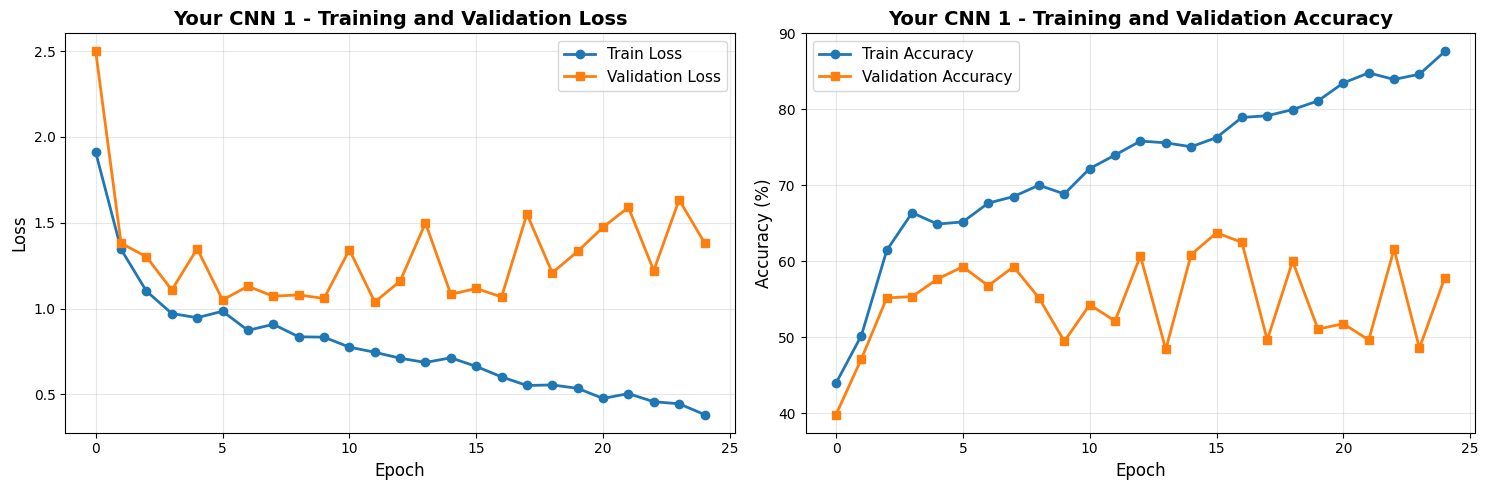


✓ Loaded best model

FINAL EVALUATION - YOUR CNN 1
Final Train Accuracy: 78.19%
Final Test Accuracy: 63.75%

MEASURING INFERENCE TIME
Average inference time: 0.23 ms per image

GENERATING PREDICTIONS FOR METRICS

Weighted Metrics:
  Precision: 0.6157
  Recall:    0.6375
  F1-Score:  0.6134


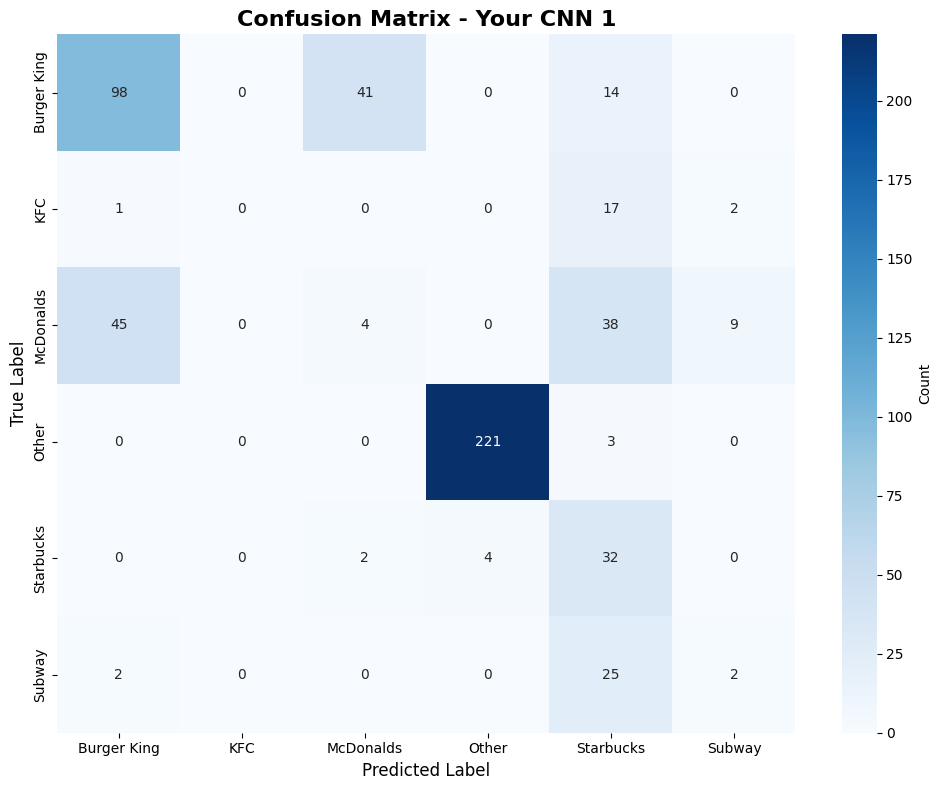


CLASSIFICATION REPORT - YOUR CNN 1
              precision    recall  f1-score   support

 Burger King     0.6712    0.6405    0.6555       153
         KFC     0.0000    0.0000    0.0000        20
   McDonalds     0.0851    0.0417    0.0559        96
       Other     0.9822    0.9866    0.9844       224
   Starbucks     0.2481    0.8421    0.3832        38
      Subway     0.1538    0.0690    0.0952        29

    accuracy                         0.6375       560
   macro avg     0.3567    0.4300    0.3624       560
weighted avg     0.6157    0.6375    0.6134       560


📊 FOR REPORT - SUMMARY TABLE

📈 Performance:
  Test Accuracy:        63.75%
  Precision (Weighted): 0.6157
  Recall (Weighted):    0.6375
  F1-Score (Weighted):  0.6134

🏗️ Architecture:
  Parameters:        57,150,630
  Layers/Blocks:     5 Conv blocks (10 Conv layers)
  Pretrained:        No

⚡ Efficiency:
  Training Time:     10.4 min
  Inference Time:    0.23 ms per image
  Memory Usage:      ~218.0 MB

📋 COPY TH

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



✓ Final model saved as 'your_cnn1_final.pt'
✓ Training history saved as 'your_cnn1_history.pt'
✓ Results saved as 'your_cnn1_results.json'

YOUR CNN 1 - ARCHITECTURE SUMMARY
Design Highlights:
  ✓ 5 Convolutional Blocks (vs 2 in Given CNN)
  ✓ Double convolutions in each block
  ✓ Batch Normalization for stable training
  ✓ Progressive channels: 32→64→128→256→512
  ✓ Dropout (0.5) for regularization
  ✓ He weight initialization

Model Statistics:
  Total Parameters: 57,150,630
  Training Samples: 1738
  Test Samples: 560
  Epochs Trained: 25
  Best Validation Accuracy: 63.75%
  Final Test Accuracy: 63.75%

ALL TASKS COMPLETED!


In [5]:
# ============================================================================
# YOUR CNN 1 - Deeper Architecture with Batch Normalization
# Design Philosophy: More convolutional layers with modern techniques
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sn
import pandas as pd
import numpy as np
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 1. DATA PREPARATION (Enhanced Data Augmentation)
# ============================================================================

train_dir = os.path.join('/content/drive/MyDrive/ene490/archive/logos3/train')
test_dir = os.path.join('/content/drive/MyDrive/ene490/archive/logos3/test')

# Strong data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),           # Standard size
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(20),           # Increased rotation
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # NEW: Translation
    transforms.ColorJitter(brightness=0.3, contrast=0.3,
                          saturation=0.3, hue=0.1),
    transforms.RandomGrayscale(p=0.1),       # NEW: Random grayscale
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet normalization
                        std=[0.229, 0.224, 0.225])
])

# Test transform (no augmentation)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# ============================================================================
# 2. HYPERPARAMETERS - YOUR CNN 1
# ============================================================================

CONFIG = {
    'num_classes': 6,
    'learning_rate': 0.001,
    'batch_size': 32,
    'num_epoch': 25,              # More epochs
    'weight_decay': 1e-4
}

num_classes = CONFIG['num_classes']
learning_rate = CONFIG['learning_rate']
batch_size = CONFIG['batch_size']
num_epoch = CONFIG['num_epoch']
weight_decay = CONFIG['weight_decay']

print(f"\nYour CNN 1 - Hyperparameters:")
print(f"  Learning Rate: {learning_rate}")
print(f"  Batch Size: {batch_size}")
print(f"  Epochs: {num_epoch}")
print(f"  Weight Decay: {weight_decay}")

# ============================================================================
# 3. LOAD DATASET
# ============================================================================

train_data = torchvision.datasets.ImageFolder(root=train_dir,
                                              transform=train_transform)
train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=test_dir,
                                             transform=test_transform)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=2)

print(f"\nDataset Info:")
print(f"  Training samples: {len(train_data)}")
print(f"  Test samples: {len(test_data)}")
print(f"  Classes: {train_data.classes}")

# ============================================================================
# 4. YOUR CNN 1 MODEL - DEEPER ARCHITECTURE
# ============================================================================

class YourCNN1(nn.Module):
    """
    Deeper CNN with Batch Normalization

    Architecture:
    - 5 Convolutional Blocks (vs 2 in Given CNN)
    - Each block: Conv → BatchNorm → ReLU → MaxPool
    - Progressive channel increase: 32 → 64 → 128 → 256 → 512
    - 3 Fully Connected layers with Dropout
    - Batch Normalization for stable training
    """

    def __init__(self, num_classes=6):
        super(YourCNN1, self).__init__()

        # Convolutional Block 1: 3 → 32
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),  # Double conv
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 224 → 112
        )

        # Convolutional Block 2: 32 → 64
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),  # Double conv
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 112 → 56
        )

        # Convolutional Block 3: 64 → 128
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),  # Double conv
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 56 → 28
        )

        # Convolutional Block 4: 128 → 256
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),  # Double conv
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 28 → 14
        )

        # Convolutional Block 5: 256 → 512
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),  # Double conv
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)  # 14 → 7
        )

        # Fully Connected Layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Initialize model
model = YourCNN1(num_classes=num_classes).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
param_size_mb = (total_params * 4) / (1024 * 1024)

print(f"\nYour CNN 1 - Model Info:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{param_size_mb:.1f} MB")

# Display model architecture
print(f"\nModel Architecture:")
print(model)

# ============================================================================
# 5. LOSS FUNCTION AND OPTIMIZER
# ============================================================================

criterion = nn.CrossEntropyLoss()

# Using Adam optimizer
optimizer = optim.Adam(model.parameters(),
                      lr=learning_rate,
                      weight_decay=weight_decay)

# Learning rate scheduler - Step decay
scheduler = optim.lr_scheduler.StepLR(optimizer,
                                      step_size=8,
                                      gamma=0.5)

# ============================================================================
# 6. TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# ============================================================================
# 7. TRAINING LOOP
# ============================================================================

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("\n" + "="*70)
print("TRAINING YOUR CNN 1")
print("="*70)

best_val_acc = 0.0

# Record training start time
train_start_time = time.time()

for epoch in range(num_epoch):
    # Train
    train_loss, train_acc = train_epoch(model, train_data_loader,
                                       criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, test_data_loader, criterion, device)

    # Save history
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'your_cnn1_best.pt')

    # Print progress
    print(f'Epoch [{epoch+1:2d}/{num_epoch}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | '
          f'LR: {current_lr:.6f}')

# Calculate training time
train_end_time = time.time()
training_time = (train_end_time - train_start_time) / 60  # in minutes

print("="*70)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Training time: {training_time:.1f} minutes")
print("="*70)

# ============================================================================
# 8. PLOT TRAINING HISTORY
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o', linewidth=2)
ax1.plot(val_losses, label='Validation Loss', marker='s', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Your CNN 1 - Training and Validation Loss',
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy', marker='o', linewidth=2)
ax2.plot(val_accuracies, label='Validation Accuracy', marker='s', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Your CNN 1 - Training and Validation Accuracy',
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('your_cnn1_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 9. LOAD BEST MODEL AND EVALUATE
# ============================================================================

# Load best model
model.load_state_dict(torch.load('your_cnn1_best.pt'))
print("\n✓ Loaded best model")

# Final evaluation
final_train_loss, final_train_acc = validate(model, train_data_loader, criterion, device)
final_val_loss, final_val_acc = validate(model, test_data_loader, criterion, device)

print("\n" + "="*70)
print("FINAL EVALUATION - YOUR CNN 1")
print("="*70)
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Accuracy: {final_val_acc:.2f}%")

# ============================================================================
# 10. INFERENCE TIME MEASUREMENT
# ============================================================================

print("\n" + "="*70)
print("MEASURING INFERENCE TIME")
print("="*70)

model.eval()
inference_times = []

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)

        # Measure inference time for each batch
        start_time = time.time()
        outputs = model(inputs)
        end_time = time.time()

        # Calculate time per image
        batch_time = (end_time - start_time) * 1000  # ms
        time_per_image = batch_time / inputs.size(0)
        inference_times.append(time_per_image)

avg_inference_ms = np.mean(inference_times)
print(f"Average inference time: {avg_inference_ms:.2f} ms per image")

# ============================================================================
# 11. CONFUSION MATRIX & DETAILED METRICS
# ============================================================================

print("\n" + "="*70)
print("GENERATING PREDICTIONS FOR METRICS")
print("="*70)

y_pred = []
y_true = []
model.eval()

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predictions = outputs.max(1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Class names
classes = train_data.classes

# Calculate precision, recall, f1-score
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

print(f"\nWeighted Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix,
                     index=classes,
                     columns=classes)

plt.figure(figsize=(10, 8))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Your CNN 1', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('your_cnn1_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 12. CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*70)
print("CLASSIFICATION REPORT - YOUR CNN 1")
print("="*70)
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# ============================================================================
# 13. SUMMARY FOR REPORT (NEW - MATCHING OTHER MODELS)
# ============================================================================

print("\n" + "="*70)
print("📊 FOR REPORT - SUMMARY TABLE")
print("="*70)
print("\n📈 Performance:")
print(f"  Test Accuracy:        {final_val_acc:.2f}%")
print(f"  Precision (Weighted): {precision:.4f}")
print(f"  Recall (Weighted):    {recall:.4f}")
print(f"  F1-Score (Weighted):  {f1:.4f}")

print("\n🏗️ Architecture:")
print(f"  Parameters:        {total_params:,}")
print(f"  Layers/Blocks:     5 Conv blocks (10 Conv layers)")
print(f"  Pretrained:        No")

print("\n⚡ Efficiency:")
print(f"  Training Time:     {training_time:.1f} min")
print(f"  Inference Time:    {avg_inference_ms:.2f} ms per image")
print(f"  Memory Usage:      ~{param_size_mb:.1f} MB")

print("\n" + "="*70)
print("📋 COPY THIS FOR YOUR COMPARISON TABLE:")
print("="*70)
print(f"Model: Your CNN 1 (Deeper)")
print(f"Test Accuracy:         {final_val_acc:.2f}%")
print(f"Precision (Weighted):  {precision:.4f}")
print(f"Recall (Weighted):     {recall:.4f}")
print(f"F1-Score (Weighted):   {f1:.4f}")
print(f"Parameters:            {total_params:,}")
print(f"Layers/Blocks:         5 Conv blocks")
print(f"Pretrained:            No")
print(f"Inference (ms):        {avg_inference_ms:.2f}")
print("="*70)

# ============================================================================
# 14. SAVE MODEL AND HISTORY
# ============================================================================

# Save final model
torch.save(model.state_dict(), "your_cnn1_final.pt")
print("\n✓ Final model saved as 'your_cnn1_final.pt'")

# Save comprehensive history
history = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'best_val_accuracy': best_val_acc,
    'final_val_accuracy': final_val_acc,
    'precision_weighted': float(precision),
    'recall_weighted': float(recall),
    'f1_weighted': float(f1),
    'total_parameters': int(total_params),
    'model_size_mb': float(param_size_mb),
    'training_time_minutes': float(training_time),
    'avg_inference_ms': float(avg_inference_ms),
    'hyperparameters': CONFIG
}
torch.save(history, 'your_cnn1_history.pt')
print("✓ Training history saved as 'your_cnn1_history.pt'")

# Save as JSON for easy reading
import json
with open('your_cnn1_results.json', 'w') as f:
    json.dump(history, f, indent=4)
print("✓ Results saved as 'your_cnn1_results.json'")

# ============================================================================
# 15. ARCHITECTURE SUMMARY
# ============================================================================

print("\n" + "="*70)
print("YOUR CNN 1 - ARCHITECTURE SUMMARY")
print("="*70)
print("Design Highlights:")
print("  ✓ 5 Convolutional Blocks (vs 2 in Given CNN)")
print("  ✓ Double convolutions in each block")
print("  ✓ Batch Normalization for stable training")
print("  ✓ Progressive channels: 32→64→128→256→512")
print("  ✓ Dropout (0.5) for regularization")
print("  ✓ He weight initialization")
print(f"\nModel Statistics:")
print(f"  Total Parameters: {total_params:,}")
print(f"  Training Samples: {len(train_data)}")
print(f"  Test Samples: {len(test_data)}")
print(f"  Epochs Trained: {num_epoch}")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Final Test Accuracy: {final_val_acc:.2f}%")
print("="*70)

print("\n" + "="*70)
print("ALL TASKS COMPLETED!")
print("="*70)

# Your CNN2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda

Your CNN 2 - Hyperparameters:
  Learning Rate: 0.001
  Batch Size: 32
  Epochs: 35
  Weight Decay: 0.0001

Dataset Info:
  Training samples: 1738
  Test samples: 560
  Classes: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']

Your CNN 2 - Model Info:
  Total parameters: 1,024,838
  Trainable parameters: 1,024,838
  Model size: ~3.9 MB

Model Architecture:
YourCNN2(
  (stage1_conv): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (stage1_res): SimpleResidualBlock(
    (conv1): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (con

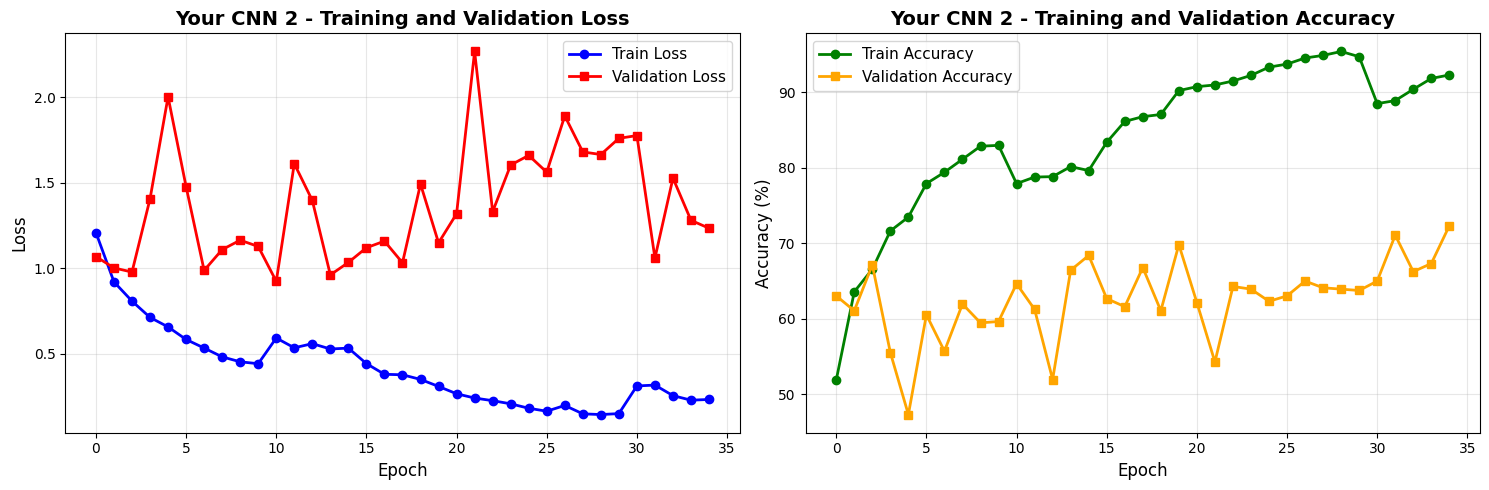


✓ Loaded best model

FINAL EVALUATION - YOUR CNN 2
Final Train Accuracy: 93.90%
Final Test Accuracy: 72.32%

MEASURING INFERENCE TIME
Average inference time: 0.14 ms per image

GENERATING PREDICTIONS FOR METRICS

Weighted Metrics:
  Precision: 0.7091
  Recall:    0.7232
  F1-Score:  0.7039


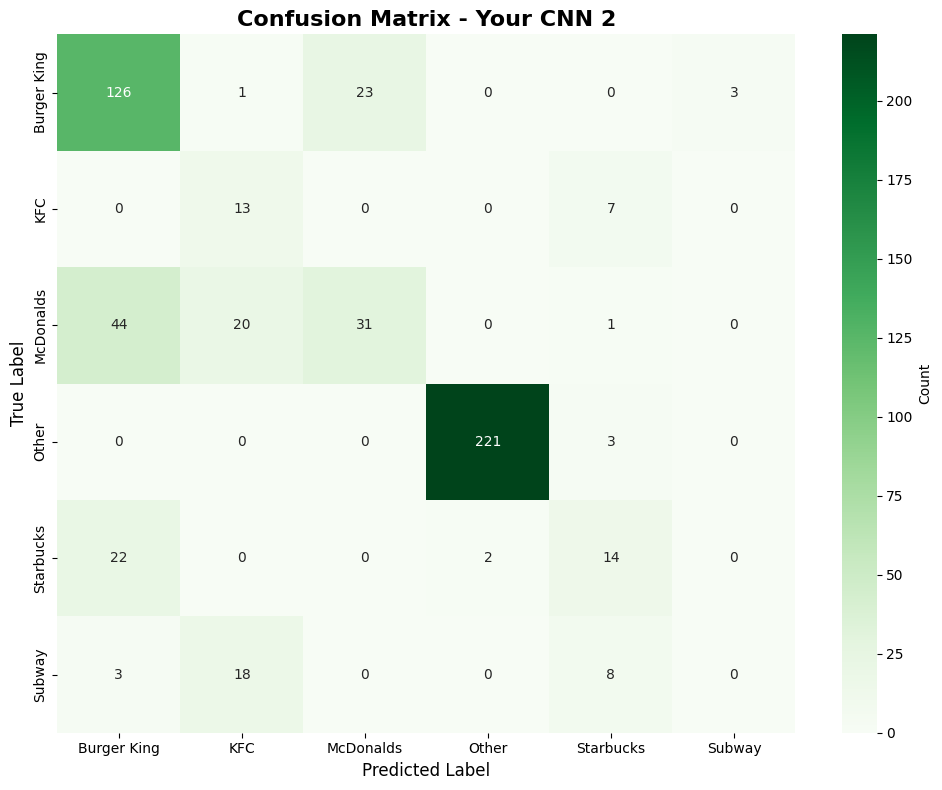


CLASSIFICATION REPORT - YOUR CNN 2
              precision    recall  f1-score   support

 Burger King     0.6462    0.8235    0.7241       153
         KFC     0.2500    0.6500    0.3611        20
   McDonalds     0.5741    0.3229    0.4133        96
       Other     0.9910    0.9866    0.9888       224
   Starbucks     0.4242    0.3684    0.3944        38
      Subway     0.0000    0.0000    0.0000        29

    accuracy                         0.7232       560
   macro avg     0.4809    0.5252    0.4803       560
weighted avg     0.7091    0.7232    0.7039       560


📊 FOR REPORT - SUMMARY TABLE

📈 Performance:
  Test Accuracy:        72.32%
  Precision (Weighted): 0.7091
  Recall (Weighted):    0.7232
  F1-Score (Weighted):  0.7039

🏗️ Architecture:
  Parameters:        1,024,838
  Layers/Blocks:     4 stages + skip connections
  Pretrained:        No

⚡ Efficiency:
  Training Time:     9.5 min
  Inference Time:    0.14 ms per image
  Memory Usage:      ~3.9 MB

📋 COPY THIS FOR 

In [7]:
# ============================================================================
# YOUR CNN 2 - Custom Architecture with Skip Connections
# Design Philosophy: Use skip connections (inspired by ResNet concept)
#                    but NOT the actual ResNet architecture
# Unique features: Custom residual-like blocks + depthwise separable conv
# ============================================================================

from google.colab import drive
drive.mount('/content/drive')

import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sn
import pandas as pd
import numpy as np
import time

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================================
# 1. DATA PREPARATION
# ============================================================================

train_dir = os.path.join('/content/drive/MyDrive/ene490/archive/logos3/train')
test_dir = os.path.join('/content/drive/MyDrive/ene490/archive/logos3/test')

# Strong augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),     # NEW: Vertical flip
    transforms.RandomRotation(20),
    transforms.RandomAffine(degrees=0, translate=(0.15, 0.15), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# Test transform
test_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

# ============================================================================
# 2. HYPERPARAMETERS
# ============================================================================

CONFIG = {
    'num_classes': 6,
    'learning_rate': 0.001,
    'batch_size': 32,
    'num_epoch': 35,              # More epochs
    'weight_decay': 1e-4
}

num_classes = CONFIG['num_classes']
learning_rate = CONFIG['learning_rate']
batch_size = CONFIG['batch_size']
num_epoch = CONFIG['num_epoch']
weight_decay = CONFIG['weight_decay']

print(f"\nYour CNN 2 - Hyperparameters:")
print(f"  Learning Rate: {learning_rate}")
print(f"  Batch Size: {batch_size}")
print(f"  Epochs: {num_epoch}")
print(f"  Weight Decay: {weight_decay}")

# ============================================================================
# 3. LOAD DATASET
# ============================================================================

train_data = torchvision.datasets.ImageFolder(root=train_dir,
                                              transform=train_transform)
train_data_loader = torch.utils.data.DataLoader(train_data,
                                                batch_size=batch_size,
                                                shuffle=True,
                                                num_workers=2)

test_data = torchvision.datasets.ImageFolder(root=test_dir,
                                             transform=test_transform)
test_data_loader = torch.utils.data.DataLoader(test_data,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               num_workers=2)

print(f"\nDataset Info:")
print(f"  Training samples: {len(train_data)}")
print(f"  Test samples: {len(test_data)}")
print(f"  Classes: {train_data.classes}")

# ============================================================================
# 4. YOUR CNN 2 MODEL - CUSTOM ARCHITECTURE WITH SKIP CONNECTIONS
# ============================================================================

class SimpleResidualBlock(nn.Module):
    """
    Custom Residual-like Block (NOT standard ResNet block)

    Features:
    - Skip connection from input to output
    - Two convolutions with same channels
    - Batch normalization
    """
    def __init__(self, channels):
        super(SimpleResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x  # Save input for skip connection

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # Add skip connection
        out += identity
        out = F.relu(out)

        return out


class DepthwiseSeparableConv(nn.Module):
    """
    Depthwise Separable Convolution
    More efficient than standard convolution
    Used in MobileNet but implemented simply here
    """
    def __init__(self, in_channels, out_channels):
        super(DepthwiseSeparableConv, self).__init__()

        # Depthwise: each input channel convolved separately
        self.depthwise = nn.Conv2d(in_channels, in_channels,
                                   kernel_size=3, padding=1,
                                   groups=in_channels, bias=False)

        # Pointwise: 1x1 conv to combine channels
        self.pointwise = nn.Conv2d(in_channels, out_channels,
                                   kernel_size=1, bias=False)

        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        x = self.bn(x)
        return F.relu(x)


class YourCNN2(nn.Module):
    """
    Custom CNN with Skip Connections and Efficient Convolutions

    Key Differences from Your CNN 1:
    1. Uses skip connections (residual-like but simpler)
    2. Uses depthwise separable convolutions (more efficient)
    3. 4 stages with different resolutions
    4. Mix of standard and residual blocks

    Architecture:
    Input (160x160x3)
    → Stage 1: Conv + Residual Block (48 channels) → 80x80
    → Stage 2: Depthwise Sep Conv + Residual Block (96 channels) → 40x40
    → Stage 3: Depthwise Sep Conv + Residual Block (192 channels) → 20x20
    → Stage 4: Depthwise Sep Conv (384 channels) → 10x10
    → Global Average Pooling
    → FC: 384→6

    Total params: ~1.2M
    """

    def __init__(self, num_classes=6):
        super(YourCNN2, self).__init__()

        # Stage 1: Initial convolution + Residual Block
        self.stage1_conv = nn.Sequential(
            nn.Conv2d(3, 48, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=True)
        )
        self.stage1_res = SimpleResidualBlock(48)
        self.stage1_pool = nn.MaxPool2d(2, 2)  # 160 → 80

        # Stage 2: Depthwise Separable Conv + Residual Block
        self.stage2_conv = DepthwiseSeparableConv(48, 96)
        self.stage2_res = SimpleResidualBlock(96)
        self.stage2_pool = nn.MaxPool2d(2, 2)  # 80 → 40

        # Stage 3: Depthwise Separable Conv + Residual Block
        self.stage3_conv = DepthwiseSeparableConv(96, 192)
        self.stage3_res = SimpleResidualBlock(192)
        self.stage3_pool = nn.MaxPool2d(2, 2)  # 40 → 20

        # Stage 4: Depthwise Separable Conv
        self.stage4_conv = DepthwiseSeparableConv(192, 384)
        self.stage4_pool = nn.MaxPool2d(2, 2)  # 20 → 10

        # Global Average Pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(384, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        # Stage 1
        x = self.stage1_conv(x)
        x = self.stage1_res(x)
        x = self.stage1_pool(x)

        # Stage 2
        x = self.stage2_conv(x)
        x = self.stage2_res(x)
        x = self.stage2_pool(x)

        # Stage 3
        x = self.stage3_conv(x)
        x = self.stage3_res(x)
        x = self.stage3_pool(x)

        # Stage 4
        x = self.stage4_conv(x)
        x = self.stage4_pool(x)

        # Global Average Pooling
        x = self.global_avg_pool(x)
        x = x.view(x.size(0), -1)

        # Classification
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Initialize model
model = YourCNN2(num_classes=num_classes).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
param_size_mb = (total_params * 4) / (1024 * 1024)

print(f"\nYour CNN 2 - Model Info:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Model size: ~{param_size_mb:.1f} MB")

# Display model architecture
print(f"\nModel Architecture:")
print(model)

# ============================================================================
# 5. LOSS FUNCTION AND OPTIMIZER
# ============================================================================

criterion = nn.CrossEntropyLoss()

# Using AdamW optimizer (Adam with better weight decay)
optimizer = optim.AdamW(model.parameters(),
                        lr=learning_rate,
                        weight_decay=weight_decay)

# Cosine Annealing with Warm Restarts
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,
                                                           T_0=10,
                                                           T_mult=2)

# ============================================================================
# 6. TRAINING FUNCTIONS
# ============================================================================

def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_idx, (data, targets) in enumerate(loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward
        outputs = model(data)
        loss = criterion(outputs, targets)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.to(device)

            outputs = model(data)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

# ============================================================================
# 7. TRAINING LOOP
# ============================================================================

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

print("\n" + "="*70)
print("TRAINING YOUR CNN 2")
print("="*70)

best_val_acc = 0.0

# Record training start time
train_start_time = time.time()

for epoch in range(num_epoch):
    # Train
    train_loss, train_acc = train_epoch(model, train_data_loader,
                                       criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate(model, test_data_loader, criterion, device)

    # Save history
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'your_cnn2_best.pt')

    # Print progress
    print(f'Epoch [{epoch+1:2d}/{num_epoch}] | '
          f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | '
          f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}% | '
          f'LR: {current_lr:.6f}')

# Calculate training time
train_end_time = time.time()
training_time = (train_end_time - train_start_time) / 60  # in minutes

print("="*70)
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"Training time: {training_time:.1f} minutes")
print("="*70)

# ============================================================================
# 8. PLOT TRAINING HISTORY
# ============================================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', marker='o', linewidth=2, color='blue')
ax1.plot(val_losses, label='Validation Loss', marker='s', linewidth=2, color='red')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Your CNN 2 - Training and Validation Loss',
             fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accuracies, label='Train Accuracy', marker='o', linewidth=2, color='green')
ax2.plot(val_accuracies, label='Validation Accuracy', marker='s', linewidth=2, color='orange')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Your CNN 2 - Training and Validation Accuracy',
             fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('your_cnn2_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 9. LOAD BEST MODEL AND EVALUATE
# ============================================================================

# Load best model
model.load_state_dict(torch.load('your_cnn2_best.pt'))
print("\n✓ Loaded best model")

# Final evaluation
final_train_loss, final_train_acc = validate(model, train_data_loader, criterion, device)
final_val_loss, final_val_acc = validate(model, test_data_loader, criterion, device)

print("\n" + "="*70)
print("FINAL EVALUATION - YOUR CNN 2")
print("="*70)
print(f"Final Train Accuracy: {final_train_acc:.2f}%")
print(f"Final Test Accuracy: {final_val_acc:.2f}%")

# ============================================================================
# 10. INFERENCE TIME MEASUREMENT
# ============================================================================

print("\n" + "="*70)
print("MEASURING INFERENCE TIME")
print("="*70)

model.eval()
inference_times = []

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)

        # Measure inference time for each batch
        start_time = time.time()
        outputs = model(inputs)
        end_time = time.time()

        # Calculate time per image
        batch_time = (end_time - start_time) * 1000  # ms
        time_per_image = batch_time / inputs.size(0)
        inference_times.append(time_per_image)

avg_inference_ms = np.mean(inference_times)
print(f"Average inference time: {avg_inference_ms:.2f} ms per image")

# ============================================================================
# 11. CONFUSION MATRIX & DETAILED METRICS
# ============================================================================

print("\n" + "="*70)
print("GENERATING PREDICTIONS FOR METRICS")
print("="*70)

y_pred = []
y_true = []
model.eval()

with torch.no_grad():
    for inputs, labels in test_data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predictions = outputs.max(1)

        y_pred.extend(predictions.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Class names
classes = train_data.classes

# Calculate precision, recall, f1-score
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, average='weighted', zero_division=0
)

print(f"\nWeighted Metrics:")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix,
                     index=classes,
                     columns=classes)

plt.figure(figsize=(10, 8))
sn.heatmap(df_cm, annot=True, fmt='d', cmap='Greens',
           xticklabels=classes, yticklabels=classes, cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Your CNN 2', fontsize=16, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('your_cnn2_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# ============================================================================
# 12. CLASSIFICATION REPORT
# ============================================================================

print("\n" + "="*70)
print("CLASSIFICATION REPORT - YOUR CNN 2")
print("="*70)
print(classification_report(y_true, y_pred, target_names=classes, digits=4))

# ============================================================================
# 13. SUMMARY FOR REPORT (NEW - MATCHING OTHER MODELS)
# ============================================================================

print("\n" + "="*70)
print("📊 FOR REPORT - SUMMARY TABLE")
print("="*70)
print("\n📈 Performance:")
print(f"  Test Accuracy:        {final_val_acc:.2f}%")
print(f"  Precision (Weighted): {precision:.4f}")
print(f"  Recall (Weighted):    {recall:.4f}")
print(f"  F1-Score (Weighted):  {f1:.4f}")

print("\n🏗️ Architecture:")
print(f"  Parameters:        {total_params:,}")
print(f"  Layers/Blocks:     4 stages + skip connections")
print(f"  Pretrained:        No")

print("\n⚡ Efficiency:")
print(f"  Training Time:     {training_time:.1f} min")
print(f"  Inference Time:    {avg_inference_ms:.2f} ms per image")
print(f"  Memory Usage:      ~{param_size_mb:.1f} MB")

print("\n" + "="*70)
print("📋 COPY THIS FOR YOUR COMPARISON TABLE:")
print("="*70)
print(f"Model: Your CNN 2 (Skip Connections)")
print(f"Test Accuracy:         {final_val_acc:.2f}%")
print(f"Precision (Weighted):  {precision:.4f}")
print(f"Recall (Weighted):     {recall:.4f}")
print(f"F1-Score (Weighted):   {f1:.4f}")
print(f"Parameters:            {total_params:,}")
print(f"Layers/Blocks:         4 stages + residual")
print(f"Pretrained:            No")
print(f"Inference (ms):        {avg_inference_ms:.2f}")
print("="*70)

# ============================================================================
# 14. SAVE MODEL AND HISTORY
# ============================================================================

# Save final model
torch.save(model.state_dict(), "your_cnn2_final.pt")
print("\n✓ Final model saved as 'your_cnn2_final.pt'")

# Save comprehensive history
history = {
    'train_losses': train_losses,
    'train_accuracies': train_accuracies,
    'val_losses': val_losses,
    'val_accuracies': val_accuracies,
    'best_val_accuracy': best_val_acc,
    'final_val_accuracy': final_val_acc,
    'precision_weighted': float(precision),
    'recall_weighted': float(recall),
    'f1_weighted': float(f1),
    'total_parameters': int(total_params),
    'model_size_mb': float(param_size_mb),
    'training_time_minutes': float(training_time),
    'avg_inference_ms': float(avg_inference_ms),
    'hyperparameters': CONFIG
}
torch.save(history, 'your_cnn2_history.pt')
print("✓ Training history saved as 'your_cnn2_history.pt'")

# Save as JSON for easy reading
import json
with open('your_cnn2_results.json', 'w') as f:
    json.dump(history, f, indent=4)
print("✓ Results saved as 'your_cnn2_results.json'")

# ============================================================================
# 15. ARCHITECTURE SUMMARY
# ============================================================================

print("\n" + "="*70)
print("YOUR CNN 2 - ARCHITECTURE SUMMARY")
print("="*70)
print("Design Philosophy:")
print("  ✓ Uses skip connections (residual-like blocks)")
print("  ✓ Depthwise separable convolutions for efficiency")
print("  ✓ 4-stage progressive feature extraction")
print("  ✓ Global Average Pooling")
print("  ✓ Different from both Given CNN and Your CNN 1")
print(f"\nKey Features:")
print(f"  - Custom residual blocks (NOT standard ResNet)")
print(f"  - Depthwise separable convolutions (efficient)")
print(f"  - Skip connections help gradient flow")
print(f"  - Input size: 160x160")
print(f"  - Channels: 48→96→192→384")
print(f"\nModel Statistics:")
print(f"  Total Parameters: {total_params:,}")
print(f"  Training Samples: {len(train_data)}")
print(f"  Test Samples: {len(test_data)}")
print(f"  Epochs Trained: {num_epoch}")
print(f"  Best Validation Accuracy: {best_val_acc:.2f}%")
print(f"  Final Test Accuracy: {final_val_acc:.2f}%")
print("="*70)

print("\n" + "="*70)
print("ALL TASKS COMPLETED!")
print("="*70)